In [627]:
% mkdir filing_texts
% mkdir prices 

mkdir: filing_texts: File exists
mkdir: prices: File exists


In [681]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
import glob
import os 
import pandas as pd
import datetime
from scipy.stats import iqr
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import math

spm = None
english_words = None
excepted_stock_names = []
limit = -1

In [629]:
import keras
from keras.layers import Dense, Dropout, RepeatVector, BatchNormalization, Convolution1D, Flatten, Lambda, Permute, MaxPooling1D, AlphaDropout
from keras.models import Sequential
from keras.utils import to_categorical
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tqdm import *

In [650]:
class DateRange():
    def __init__(self, start_int, end_int):
        self.start_int = start_int
        self.end_int = end_int
        self.range = (range(start_int, end_int))

    def transform(self, date):
        output = {}
        dates = []
        for delta in self.range:
            date_delta = datetime.timedelta(days=delta)
            date_string = datetime.datetime.strptime(date, '%Y-%m-%d').date()
            dates.append(str(date_string + date_delta))
        return dates

In [697]:
class SNDM():
    def __init__(self, limit=-1):
        self.limit = limit
        self.sndm = self.__get_sndm()

    def __get_sndm(self):
        spm = self.__stock_name_date_mapping()
        output = {}
        for stock_name in spm.keys():
            numerical_prices = 0
            for date in DateRange(-3,2).transform(spm[stock_name]['date']):
                try:
                    isnan = math.isnan(PriceData(stock_name).on_date(date, 'open'))
                except:
                    isnan = True
                if not (isnan):
                    numerical_prices += 1 
            # Delete stock_name from spm if numerical prices under a threshold. (nans)
            if numerical_prices >= 3:
                output[stock_name] = spm[stock_name]
        return output
    
    def __stock_name_date_mapping(self):
        spm = {}
        for i, file in enumerate(glob.glob('filing_texts/*')[0:self.limit]):
            try:
                stock_name = self.__stock_name_from_filename(file)
                file_data = open(file, 'r').read()[:200]
                time_data = file_data.split('<ACCEPTANCE-DATETIME>')[1].split('\\n')[0][:8]
                year = time_data[0:4]
                month = time_data[4:6]
                day = time_data[6:8]
                date_stamp = ("%s-%s-%s" %(year, month, day))
                spm[stock_name] = {'date': date_stamp}
            except:
                print("No data for ", stock_name)
                excepted_stock_names.append(stock_name)
                continue
        return spm
    def __stock_name_from_filename(filename):
        return filename.split('/')[-1].split('_')[0]

In [656]:
class PriceData:
    def __init__(self, stock_name):
        self.stock_name = stock_name
        try:
            self.price_data = pd.read_csv('prices/' + stock_name + '.csv')
        except:
            self.price_data = pd.DataFrame.from_dict({})

    def on_date(self, date, market_time = 'open'): 
        try:
            return float(self.price_data.loc[self.price_data['date'] == date][market_time])
        except: 
            return None

In [657]:
class FilenamesToStockNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        output = []
        for filename in X:
            stock_name = self.__stock_name_from_filename(filename)
            output.append(stock_name)
        return output
    def __stock_name_from_filename(self, filename):
        return filename.split('/')[-1].split('_')[0]

In [717]:
## Used in y pipeline
class SpmToFileNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    def transform(self, X):
        output = []
        for key in X.keys():
            date = X[key]['date']
            output.append(f'filing_texts/{key}_{date}')
        return output
    
class SpmToStockNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return X.keys()
    
class StockNamesToFileNamesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return [f'filing_texts/{stock_name}' for stock_name in X]
    
# class MapStockNamesToDatesTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, start_int, end_int):
#         self.start_int = start_int
#         self.end_int = end_int
#         self.range = (range(start_int, end_int))
    
#     def fit(self, X, y=None):
#         return self
    
#     def fit_transform(self, X, y=None):
#         return self.fit(X, y).transform(X)
        
#     def transform(self, X):
#         output = {}
#         for i, stock_name in enumerate(X):
#             try:
#                 date = spm[stock_name]['date']
#             except:
#                 continue # Ignore stocks which don't have a date
#             dates = []
#             for delta in self.range:
#                 date_delta = datetime.timedelta(days=delta)
#                 date_string = datetime.datetime.strptime(date, '%Y-%m-%d').date()
#                 dates.append(str(date_string + date_delta))
#             output[stock_name] = dates
#         return output
# class StockNameDatesMapToPricesListTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         return None
    
#     def fit(self, X, y=None):
#         return self
    
#     def fit_transform(self, X, y=None):
#         return self.fit(X, y).transform(X)
        
#     def transform(self, X):
#         output = []
#         for stock_name in X.keys():
#             prices = []
#             for date in X[stock_name]:
#                 prices.append(PriceData(stock_name).on_date(date, 'open'))
#             output.append(prices)
#         return np.array(output)
    
# class LabelsTransform(BaseEstimator, TransformerMixin):
#     # Returns the interquartile-range and median.
#     def __init__(self):
#         return None
        
#     def fit(self, X, y=None):
#         return self
    
#     def fit_transform(self, X, y=None):
#         return self.fit(X, y).transform(X)
        
#     def transform(self, X):
#         # ldcom = last_day_change_over_median
#         print(X.shape)
#         ldcom = []
#         for prices in X:
#             this_median = np.median(prices[0:-3])
#             ldcom.append(((prices[-1]-this_median)/this_median))
#         return np.array(ldcom)
            
class StatisticalMeasuresTransformer(BaseEstimator, TransformerMixin):
    # Returns the interquartile-range and median.
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        # ldcom = last_day_change_over_median
        
        output = []
        self.iqr_var = []
        self.median = []
        for prices in X:
            this_iqr = iqr(prices[0:-3])
            this_median = np.median(prices[0:-3])
            self.iqr_var.append(this_iqr)
            self.median.append(this_median)
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        X_output = []
        for i, prices in enumerate(X):
            stats   = []
            iqr_var = self.iqr_var[i] or iqr(prices)
            median  = self.median[i]  or np.median(prices)
            
            stats.append(iqr_var)
            stats.append(median)
            
            X_output.append(stats)
        return np.array(X_output)
class SparseToArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return np.array(X.toarray()) #[ar.toarray() for ar in X]
    
class ReadFiles(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        return (open(filename, 'r').read() for filename in tqdm(X))
            

In [659]:
def get_filenames(limit = -1):
    filenames = []
    directory_files = glob.glob('filing_texts/*')
    excepted_files = [('filing_texts/' + sn) for sn in excepted_stock_names]
    filenames_with_data = [x for x in directory_files[:limit] if x not in excepted_files]
    for filename in filenames_with_data:
        filenames.append(filename)
    return filenames

In [774]:
spm = SNDM().sndm

In [828]:
class StockNamesToLabelsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, start_int, end_int):
        self.filing_int = start_int * -1
        self.start_int = start_int
        self.end_int = end_int
        self.range = (range(start_int, end_int))
    # Not implemented since only used to generate labels
    def fit(self, X, y=None):
        return self
    # Not implemented since only used to generate labels
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def transform(self, X):
        h = {}
        for i, stock_name in enumerate(X):
            try:
                date = spm[stock_name]['date']
            except:
                continue # Ignore stocks which don't have a date
            dates = []
            for delta in self.range:
                date_delta = datetime.timedelta(days=delta)
                date_string = datetime.datetime.strptime(date, '%Y-%m-%d').date()
                dates.append(str(date_string + date_delta))
            h[stock_name] = dates
        
        ldcom = []
        for stock_name in h.keys():
            earliest_price_after_filing = None
            hist_p = []
            for i, date in enumerate(h[stock_name]):
                price = PriceData(stock_name).on_date(date, 'open')
                if price and not math.isnan(price):
                    if i > self.filing_int:
                        earliest_price_after_filing = earliest_price_after_filing or price
                    else:
                        hist_p.append(price)
            # Closing price on day of filing
            price_close_filing = PriceData(stock_name).on_date(h[stock_name][self.filing_int], 'close')
            # Use either the next open day of trading or the close price on day of filing
            comparison_price = earliest_price_after_filing or price_close_filing
            # Remove nans from historical prices before taking the mean
            this_mean = np.mean(hist_p)
            ldcom.append(((comparison_price-this_mean)/this_mean))
        return np.array(ldcom)

In [829]:
StockNamesToLabelsTransformer(-5,5).transform(['XOXO'])

32.78


array([ 0.01682823])

In [831]:
# Used to build other pipelines
from sklearn.preprocessing import Imputer

# prices_pipeline = Pipeline([
#     ('spm_to_filenames', SpmToFileNamesTransformer()),
#     ('filenames_to_stock_names', FilenamesToStockNamesTransformer()),
#     ('stock_names_to_dates', MapStockNamesToDatesTransformer(-5, 2)),
#     ('dates_to_prices_transformer', StockNameDatesMapToPricesListTransformer()),
#     ('imputer', Imputer(axis=1))
# ])

labels_pipeline = Pipeline([
    ('spm_to_filenames', SpmToFileNamesTransformer()),
    ('filenames_to_stock_names', FilenamesToStockNamesTransformer()),
    ('dates_to_prices_transformer', StockNamesToLabelsTransformer(-5,2))
])

# Used as the final y values 
# labels_pipeline = Pipeline([
#     ('prices_pipeline', prices_pipeline),
#     ('labels_transform', LabelsTransform())
# ])

# Used for training and test set features
stock_stats = Pipeline([
    ('prices_pipeline', prices_pipeline),
    ('stats_transform', StatisticalMeasuresTransformer())
])

# Used for training and test set features 
# ('stock_names_to_file_names', StockNamesToFileNamesTransformer()),
text_word_counts = Pipeline([
    ('spm_to_file_names', SpmToFileNamesTransformer()),
    ('read_files', ReadFiles()),
    ('vect', TfidfVectorizer(
                token_pattern=r"[a-zA-Z]+", 
                min_df = 0.10,
                max_df = 0.80,
                stop_words = 'english',
                max_features=9000,
                ngram_range=(1, 1))),
    ('sparse_to_array', SparseToArray()),
    ('std_scaler', StandardScaler()),
])


In [834]:
X = text_word_counts.fit_transform(spm)
y = labels_pipeline.fit_transform(spm)
print(X.shape)
print(y.shape)

In [833]:
X_train, X_test, y_train_continuous, y_test_continuous = train_test_split(X, y, test_size=0.2, random_state=42)

In [1033]:
def bool_arr(arr, limit=0.5):
    y_bool = []
    for num in arr:
        if num >= limit:
            y_bool.append(1)
        else:
            y_bool.append(0)
    return np.array(y_bool)
y_train = bool_arr(y_train_continuous, 0.05)
y_test = bool_arr(y_test_continuous, 0.00)

In [1034]:
from sklearn.feature_selection import SelectFpr
from sklearn.model_selection import GridSearchCV, cross_val_score

svc_train_pipeline = Pipeline([
    ('reduce_false_pos', SelectFpr(alpha=0.1)),
    ('svc', GridSearchCV(estimator=SVC(gamma='auto'), param_grid=dict(C=np.logspace(-1,3)), n_jobs=1))
])
svc_train_pipeline.fit(X_train, y_train)
svc_train_pipeline.score(X_test, y_test)

0.34210526315789475

In [1035]:
from sklearn.svm import SVC

clf = SVC(C=100)
# clf = RandomForestRegressor(n_estimators=200, max_depth=3, verbose=1, n_jobs=2)
clf.fit(X_train, y_train)

/Users/Piper/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [1036]:
from keras import regularizers
from sklearn.metrics import confusion_matrix

In [1041]:
class DeepEstimator():
    def __init__(self):
        return None
    def fit(self, X, y=None):
        class_weight = {0: 0.1,
                1: 0.9}
        self.model = self.__define_model(X)
        self.model.fit(X, y, class_weight=class_weight)
        sched = [[0.0001, 2], [0.001, 20], [0.01, 2], [0.1, 2], [0.5, 1], [0.1, 5], [0.01, 20], [0.001, 40], [0.0001, 80], [0.00005, 120]]
        for lr, epochs in sched:
            m1.optimizer.lr = lr
            m1.fit(np.array(X_train), np.array(y_train), epochs=epochs,  batch_size=64, validation_data=(np.array(X_test), np.array(y_test)))
        return self
    def predict(self, X, y=None):
        return self.model.predict(X)
    def __define_model(self, X):
        shape = X.shape[1]
        model = Sequential([
            BatchNormalization(input_shape=(shape,)),
            Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
            Dropout(0.8),
            BatchNormalization(),
            Dense(1, activation='sigmoid')   
        ])

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model
    

In [1044]:
deep_train_pipeline = Pipeline([
    ('reduce_false_pos', SelectFpr(alpha=0.75)),
    ('deep', DeepEstimator())
])
deep_train_pipeline.fit(X_train, y_train)

Epoch 1/1
150/150 [==============================] - 2s 14ms/step - loss: 16.1550 - acc: 0.5200
Train on 150 samples, validate on 38 samples
Epoch 1/2
150/150 [==============================] - 0s 548us/step - loss: 0.3882 - acc: 0.9933 - val_loss: 3.2588 - val_acc: 0.4211
Epoch 2/2
150/150 [==============================] - 0s 539us/step - loss: 0.3984 - acc: 0.9867 - val_loss: 3.2462 - val_acc: 0.4211
Train on 150 samples, validate on 38 samples
Epoch 1/20
150/150 [==============================] - 0s 403us/step - loss: 0.3824 - acc: 0.9933 - val_loss: 3.2289 - val_acc: 0.4211
Epoch 2/20
150/150 [==============================] - 0s 303us/step - loss: 0.3790 - acc: 0.9867 - val_loss: 3.2454 - val_acc: 0.4211
Epoch 3/20
150/150 [==============================] - 0s 457us/step - loss: 0.3629 - acc: 0.9867 - val_loss: 3.2566 - val_acc: 0.4211
Epoch 4/20
150/150 [==============================] - 0s 511us/step - loss: 0.3626 - acc: 0.9933 - val_loss: 3.2594 - val_acc: 0.4211
Epoch 5/20
1

Epoch 7/40
150/150 [==============================] - 0s 544us/step - loss: 0.4086 - acc: 0.9733 - val_loss: 3.2210 - val_acc: 0.4211
Epoch 8/40
150/150 [==============================] - 0s 768us/step - loss: 0.3863 - acc: 0.9733 - val_loss: 3.2891 - val_acc: 0.4211
Epoch 9/40
150/150 [==============================] - 0s 579us/step - loss: 0.4229 - acc: 0.9800 - val_loss: 3.2873 - val_acc: 0.4211
Epoch 10/40
150/150 [==============================] - 0s 615us/step - loss: 0.4162 - acc: 0.9867 - val_loss: 3.2832 - val_acc: 0.4211
Epoch 11/40
150/150 [==============================] - 0s 477us/step - loss: 0.4248 - acc: 0.9867 - val_loss: 3.2666 - val_acc: 0.4211
Epoch 12/40
150/150 [==============================] - 0s 450us/step - loss: 0.4610 - acc: 0.9867 - val_loss: 3.2593 - val_acc: 0.4211
Epoch 13/40
150/150 [==============================] - 0s 462us/step - loss: 0.4647 - acc: 0.9867 - val_loss: 3.2751 - val_acc: 0.3947
Epoch 14/40
150/150 [==============================] - 0s 

150/150 [==============================] - 0s 464us/step - loss: 0.4161 - acc: 0.9867 - val_loss: 3.1406 - val_acc: 0.4211
Epoch 28/80
150/150 [==============================] - 0s 604us/step - loss: 0.3941 - acc: 0.9867 - val_loss: 3.1506 - val_acc: 0.3947
Epoch 29/80
150/150 [==============================] - 0s 499us/step - loss: 0.3959 - acc: 0.9867 - val_loss: 3.1769 - val_acc: 0.3947
Epoch 30/80
150/150 [==============================] - 0s 677us/step - loss: 0.3691 - acc: 0.9933 - val_loss: 3.1622 - val_acc: 0.3947
Epoch 31/80
150/150 [==============================] - 0s 655us/step - loss: 0.3620 - acc: 0.9867 - val_loss: 3.1208 - val_acc: 0.3947
Epoch 32/80
150/150 [==============================] - 0s 543us/step - loss: 0.4000 - acc: 0.9600 - val_loss: 3.0863 - val_acc: 0.3947
Epoch 33/80
150/150 [==============================] - 0s 636us/step - loss: 0.3776 - acc: 0.9933 - val_loss: 3.0521 - val_acc: 0.3684
Epoch 34/80
150/150 [==============================] - 0s 557us/ste

150/150 [==============================] - 0s 450us/step - loss: 0.5405 - acc: 0.9600 - val_loss: 3.6459 - val_acc: 0.3947
Epoch 8/120
150/150 [==============================] - 0s 406us/step - loss: 0.5494 - acc: 0.9800 - val_loss: 3.4786 - val_acc: 0.4211
Epoch 9/120
150/150 [==============================] - 0s 486us/step - loss: 0.5497 - acc: 0.9800 - val_loss: 3.3582 - val_acc: 0.3947
Epoch 10/120
150/150 [==============================] - 0s 367us/step - loss: 0.5911 - acc: 0.9733 - val_loss: 3.2840 - val_acc: 0.3947
Epoch 11/120
150/150 [==============================] - 0s 405us/step - loss: 0.5928 - acc: 0.9800 - val_loss: 3.2561 - val_acc: 0.3947
Epoch 12/120
150/150 [==============================] - 0s 471us/step - loss: 0.5757 - acc: 0.9733 - val_loss: 3.2225 - val_acc: 0.4211
Epoch 13/120
150/150 [==============================] - 0s 528us/step - loss: 0.5838 - acc: 0.9800 - val_loss: 3.1961 - val_acc: 0.3947
Epoch 14/120
150/150 [==============================] - 0s 427u

150/150 [==============================] - 0s 442us/step - loss: 0.4553 - acc: 0.9867 - val_loss: 3.4407 - val_acc: 0.3684
Epoch 68/120
150/150 [==============================] - 0s 417us/step - loss: 0.4278 - acc: 0.9933 - val_loss: 3.4219 - val_acc: 0.3684
Epoch 69/120
150/150 [==============================] - 0s 381us/step - loss: 0.4118 - acc: 0.9933 - val_loss: 3.3925 - val_acc: 0.3947
Epoch 70/120
150/150 [==============================] - 0s 493us/step - loss: 0.4637 - acc: 0.9600 - val_loss: 3.3310 - val_acc: 0.3947
Epoch 71/120
150/150 [==============================] - 0s 468us/step - loss: 0.4015 - acc: 0.9867 - val_loss: 3.3016 - val_acc: 0.3947
Epoch 72/120
150/150 [==============================] - 0s 473us/step - loss: 0.4486 - acc: 0.9533 - val_loss: 3.2451 - val_acc: 0.3947
Epoch 73/120
150/150 [==============================] - 0s 482us/step - loss: 0.4260 - acc: 0.9800 - val_loss: 3.1485 - val_acc: 0.3684
Epoch 74/120
150/150 [==============================] - 0s 42

Pipeline(memory=None,
     steps=[('reduce_false_pos', SelectFpr(alpha=0.75, score_func=<function f_classif at 0x1a2e6e78c8>)), ('deep', <__main__.DeepEstimator object at 0x1a1a6662b0>)])

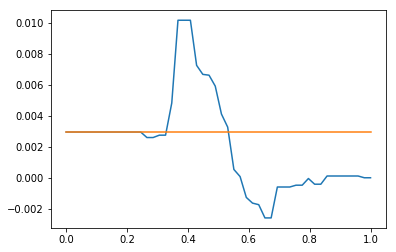

In [1045]:
import matplotlib.pyplot as plt
%matplotlib inline

def score(est, X, y, cutoff=0.75):
    y_pred = est.predict(X)
    # Invest if over 50% confident 
    y_pred_bool = bool_arr(y_pred, cutoff)
    # Score correct if you make postive returns
    y_true_bool = bool_arr(y, 0)
    total = np.dot(y_pred_bool.reshape(X.shape[0],), y)
    buy_all = np.dot(np.ones(X.shape[0]), y)
    av = total/len(X)
    buy_all_av = buy_all/len(X)
#     print(confusion_matrix(y_true_bool, y_pred_bool))
    return [av, buy_all_av]


ys_attained = []
ys_potential = []
xs = []
for i in np.linspace(0, 1):
    sc = score(deep_train_pipeline, X_test, y_test_continuous,i)
    ys_attained.append(sc[0])
    ys_potential.append(sc[1])
    xs.append(i)
plt.plot(xs, ys_attained)
plt.plot(xs, ys_potential)


In [1026]:
bool_arr(deep_train_pipeline.predict(X_test))

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])

In [ ]:
# # Factors to look into including: 
# "BookValue" = (Total Assets - Total Liabilities) / Number of shares outstanding
# "MarketCap" = Market price per share * number of shares 
# "DividendYield" = Dividend / Market price per share 
# "EarningsPerShare" 
# "PERatio2" = Market price per share / earning per share 
# "priceBook" = Market price per share / ((Total Assets - Total Liabilities) / Number of shares outstanding)
# "PriceSales" = MarketCap / Revenue 
# "Ask"


In [ ]:
# vocab = list(text_word_counts.steps[2][1].vocabulary_.keys())
# import operator
# iv_dict = [[vocab[i],-float(f)] for i,f in enumerate(clf.coef_)]
# most_important_terms = sorted(iv_dict, key=operator.itemgetter(1))[0:100]
# print(most_important_terms)
# most_important_vocab = dict(most_important_terms).keys()

In [ ]:
# from joblib import Memory
# %mkdir cachedir
# location = './cachedir'
# memory = Memory(location, verbose=0)
# stock_name_date_mapping = memory.cache(stock_name_date_mapping)

In [ ]:
# # print(text_word_counts.steps[1][1].vocabulary_)
# def get_excepted_stock_names(limit=-1):
#     esn = {}
#     for i, file in tqdm(enumerate(glob.glob('filing_texts/*')[0:limit])):
#         stock_name = stock_name_from_filename(file)
#         file_data = open(file, 'r').read()
#         try:
#             with open(file) as open_file:
#                 file_data = [next(open_file) for x in range(3)]
#             file_data = ''.join(file_data)
#             time_data = file_data.split("\n")[2][5:14]
#         except:
#             esn[i] = stock_name
#             continue
#     return esn

# def get_x_mask(X, y, filenames):
#     no_date_indices = []
#     if X.shape[0] != len(y):
#         stock_names = FilenamesToStockNamesTransformer().transform(filenames)
#         for i, stock_name in enumerate(stock_names): 
#             try:
#                 date = spm[stock_name]['date']
#             except:
#                 no_date_indices.append(i)
#         mask = np.ones(X.shape[0], dtype=bool)
#         mask[no_date_indices] = False
#         X_mask = X[mask]
#     else:
#         X_mask = X
#     return X_mask